# docs

- doc-text-detect: https://cloud.google.com/vision/docs/fulltext-annotations

# move file

In [ ]:
from glob import glob 
import os

In [ ]:
# for pdf in pdf_list:
#     old_dirname = os.path.dirname(pdf)
#     old_basename = os.path.basename(pdf)  
#     new_dirname = old_dirname[:-1] + temp_dict[old_dirname[-1]] + '/pdf'
#     os.makedirs(new_dirname, exist_ok=True)
#     new_pdf = os.path.join(new_dirname, old_basename)
#     os.rename(pdf, new_pdf)

In [ ]:
# import shutil
# folder_list = glob('/home/ryh/embedding-match/ocr/datasets/age/13to15/press/108/*/*/題')
# folder_list
# for folder in folder_list:
#     shutil.rmtree(folder)

# Ocr

In [1]:
from pdf2image import convert_from_path
from google.cloud import vision
import io
from glob import glob 
import os
import re
import pandas as pd
from datetime import datetime

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches

class Ocr:
    def __init__(self):
        self.vision_client = vision.ImageAnnotatorClient() 
        self.setup_paper_log()
    
    def get_pdf_path_list(self, year='*', subject='*', press='*', qa='question'):
        d = '/home/ryh/embedding-match/ocr/datasets/taiwan/13to15/press/%s/%s/%s/%s/pdf/*.pdf'%(year, subject, press, qa)
        pdf_list = sorted(glob(d))
        return pdf_list
    
    def get_paper_path_list(self, year='*', subject='*', press='*', qa='question', pdf_path=''):
        pdf_path = os.path.basename(pdf_path)
        pdf_path = pdf_path.replace('.pdf', '').replace('[', '*').replace(']', '*')
        d = '/home/ryh/embedding-match/ocr/datasets/taiwan/13to15/press/%s/%s/%s/%s/paper/%s*.png'%(year, subject, press, qa, pdf_path)
        pdf_list = sorted(glob(d))
        return pdf_list
    
    def pdf2papers(self, pdf_path):
        images = self.pdf2images(pdf_path)
        old_dirname = os.path.dirname(pdf_path)
        old_basename = os.path.basename(pdf_path)
        new_dirname = old_dirname.replace('pdf', 'paper')
        for i, image in enumerate(images):     
            j = i+1
            print(j, len(images), end='\r')
            new_basename = old_basename.replace('.pdf', '') + '---%02d'%(j) + '.png' # "%02d"
            img_path = os.path.join(new_dirname, new_basename)
            self.save_image(image, img_path)
    
    def pdf2images(self, pdf_path):
        images = convert_from_path(pdf_path)
        return images
    
    def save_image(self, image, img_path):
        image.save(img_path, 'PNG')
        
    def setup_paper(self, paper_path):
        self.paper_path = paper_path
        with open(paper_path, 'rb') as f:
            self.paper_byte = f.read()
        self.paper_arr = mpimg.imread(paper_path)
        self.page = 'xxx'
        
        self.ann_list = self.get_text_annotation_list(self.paper_byte)
        self.q_ann_list = self.filter_text_annotation_list(self.ann_list)
        self.setup_vertical_line(ann_list=self.q_ann_list)
        self.q_list = self.get_q_list(self.q_ann_list)
        self.setup_is_special()
    
    def setup_is_special(self):
        is_special = 0
        for q in self.q_list:
            edgecolor = self.get_edgecolor(q['text'])
            if edgecolor == 'b': is_special = 1
        self.is_special = is_special

    def setup_page(self, txt='12-2bcc', ann=None):
        xy, xy_float, rec_width, rec_height, text = self.get_rec_info(ann)
        y_float = xy_float[1] 
        if y_float < 0.2 or y_float > 0.8:
            pat = '^(\(|\{)?([1-9]|1[0-9])(-|–)([1-2])'
            x = re.search(pat, txt)
            if x != None:
                self.page = x.group(0).replace('–', '-').replace('(', '').replace('{', '')        
    
    def setup_vertical_line(self, ann_list=[]):
        left = []
        right = []
        for ann in ann_list:
            xy, xy_float, rec_width, rec_height, text = ocr.get_rec_info(ann)
            x_, y_ =  xy_float[0], xy_float[1]
            x, y =  xy[0], xy[1]
            if x_ < 0.5:
                left.append(x)
            else:
                right.append(x)
        self.left_x = min(left) if len(left) != 0 else 'xxx'
        self.right_x = min(right) if len(right) != 0 else 'xxx'

    def setup_paper_log(self):
        self.paper_log_path = '/home/ryh/embedding-match/ocr/datasets/paper_log.pickle'
        
        try:
            self.paper_log = pd.read_pickle(self.paper_log_path)
        except:
            self.paper_log = pd.DataFrame(columns=['pdf_path', 'paper_path', 'q_list', 'page', 'is_special', 'is_check', 'is_split'])
            
        self.paper_path_set = set(self.paper_log.paper_path.values)

    def save_paper_to_paper_log(self):
        df_paper = pd.DataFrame()
        df_paper['pdf_path'] = [self.paper_path.split('---')[0].replace('paper', 'pdf') + '.pdf']
        df_paper['paper_path'] = [self.paper_path]
        df_paper['q_list'] = [self.q_list]
        df_paper['page'] = [self.page]
        df_paper['is_special'] = [self.is_special]
        df_paper['is_check'] = [0]
        df_paper['is_split'] = [0]
        
        self.paper_log = self.paper_log.append(df_paper)
        self.paper_log.to_pickle(self.paper_log_path)
        self.paper_path_set.add(self.paper_path)
        
    def save_paper_log(self, paper_log):
        paper_log = paper_log.sort_values(by='paper_path', ascending=True).reset_index(drop=True)
        paper_log.to_pickle(self.paper_log_path)
        self.setup_paper_log()
        
    def get_text_annotation_list(self, content):
        image = vision.Image(content=content)
        response = self.vision_client.text_detection(image=image)
        text_annotation_list = response.text_annotations
        return text_annotation_list[1:]
    
    def image2byte(self, image):
        img_byte_arr = io.BytesIO()
        image.save(img_byte_arr, format='PNG')
        img_byte_arr = img_byte_arr.getvalue()
        return img_byte_arr
    
    def get_rec_info(self, text_annotation):
        paper_height, paper_width = self.paper_arr.shape[0], self.paper_arr.shape[1]
        vertices = text_annotation.bounding_poly.vertices
        xy0 = vertices[0] # 左下
        xy1 = vertices[1] # 右下
        xy2 = vertices[2] # 右上
        xy3 = vertices[3] # 左上
        xy = (xy0.x, xy0.y)
        xy_float = (xy0.x / paper_width, xy0.y / paper_height)
        rec_width = xy1.x - xy0.x
        rec_height = xy3.y - xy0.y
        text = text_annotation.description
        return xy, xy_float, rec_width, rec_height, text

    def filter_text_annotation_list(self, text_annotation_list):
        result = []
        for i, text_annotation in enumerate(text_annotation_list):
            if self.is_include(text_annotation) == True:
                result.append(text_annotation) 
                continue
                
            txt = text_annotation_list[i:i+5]
            txt = ''.join([x.description for x in txt])
            c1 = self.is_valid_txt(txt)
            c2 = self.is_valid_x_position(text_annotation)
            c3 = self.pre_is_valid(i, text_annotation_list)
            #print(i, txt)
            if c1 and c2 and c3:                
                if self.is_words_below(i, text_annotation_list) == False:
                    if self.is_exclude(text_annotation) == False:
                        result.append(text_annotation) 
            
            # 找第幾頁
            self.setup_page(txt, text_annotation)
            
        return result
    
    def is_words_below(self, i, text_annotation_list):
        #print('#'*50)
        ann_num = len(text_annotation_list) // 10
        ann_list = text_annotation_list[i+1:i+ann_num]
        cur = text_annotation_list[i]
        for ann in ann_list:
            if self.is_word_below(cur, ann) == True:
                return True
        return False
    
    def is_word_below(self, ann1, ann2):
        _, ann1_xy_float, _, _, _ = self.get_rec_info(ann1)
        ann1_x, ann1_y = ann1_xy_float[0], ann1_xy_float[1]
        
        _, ann2_xy_float, _, _, _ = self.get_rec_info(ann2)
        ann2_x, ann2_y = ann2_xy_float[0], ann2_xy_float[1]
        x_diff = abs(ann1_x-ann2_x) 
        y_diff = abs(ann1_y-ann2_y)
        
        # 在正下方，所以 dx接近0，dy大於某個數值但不能太大
        c1 = x_diff < 0.005 # 0.01 0.011
        c2 = 0.05 > y_diff > 0.01
        c = c1 and c2
        #print(ann1.description, ann2.description, x_diff, y_diff, c1, c2, c)        
        if c: return True
        return False
    
    def pre_is_valid(self, i, text_annotation_list):
        if i==0: return True
        cur = text_annotation_list[i]
        pre = text_annotation_list[i-1]
        _, cur_xy_float, _, _, _ = self.get_rec_info(cur)
        _, pre_xy_float, _, _, _ = self.get_rec_info(pre)
        cur_x, cur_y = cur_xy_float[0], cur_xy_float[1]
        pre_x, pre_y = pre_xy_float[0], pre_xy_float[1]
        x_diff, y_diff = abs(cur_x-pre_x), abs(cur_y-pre_y)
        pre_text = pre.description
        
        # cur跟pre都在同一邊
        # 假如前一個字不是 ")" 就有問題
        if (cur_x < 0.3 and pre_x < 0.3) or (cur_x > 0.5 and pre_x > 0.5):
            if x_diff < 0.05 and y_diff < 0.03 and pre_text != ')':
                return False
        return True
    
    def is_exclude(self, text_annotation):
        xy, xy_float, rec_width, rec_height, text = self.get_rec_info(text_annotation)
        if [xy_float, text] == [(0.08658420551855375, 0.19602735265385868), '3.5']: return True # /home/ryh/embedding-match/ocr/datasets/taiwan/13to15/press/108/數學/南一/question/paper/108下-南一國中試卷數學(2)C卷題---32.png
        return False
    
    def is_include(self, text_annotation):
        xy, xy_float, rec_width, rec_height, text = self.get_rec_info(text_annotation)
        if [xy_float, text] == [(0.5423406279733587, 0.6805600781504396), '若']: return True # /home/ryh/embedding-match/ocr/datasets/taiwan/13to15/press/108/數學/南一/question/paper/108下-南一國中試卷數學(2)C卷題---17.png
        return False
        
    def is_valid_txt(self, txt):
        pat = '^([1-9]|[1-2][0-9])(\.)(.)(.)'
        x = re.search(pat, txt)
        return (x != None)
    
    def is_valid_x_position(self, text_annotation):
        # x的位置
        xy, xy_float, rec_width, rec_height, text = self.get_rec_info(text_annotation)
        x_float, y_float = xy_float[0], xy_float[1]
        is_valid = (0.15 > x_float > 0) or (0.6 > x_float > 0.49)
        return is_valid
    
    def show_paper(self, paper_path='', q_list=[], show_border=False, show_rec=True):
        img = mpimg.imread(paper_path)
        img_height, img_width = img.shape[0], img.shape[1]
        d = 50
        fig, ax = plt.subplots(figsize=(img_height/d, img_width/d), dpi=d)
        
        for q in q_list:
            if show_rec:
                xy, xy_float, rec_width, rec_height, text = q['xy'], q['xy_float'], q['rec_width'], q['rec_height'], q['text']
                edgecolor = self.get_edgecolor(text)
                rect = patches.Rectangle(xy, rec_width, rec_height, linewidth=2, edgecolor=edgecolor, facecolor='none')
                ax.add_patch(rect)
                
            if show_border:
                coor = q['coor']
                x1, x2, y1, y2 = coor['x1'], coor['x2'], coor['y1'], coor['y2']
                xy = (x1, y1)
                rec_width = abs(x2 - x1)
                rec_height = abs(y2 - y1)
                rect = patches.Rectangle(xy, rec_width, rec_height, linewidth=2, edgecolor='g', facecolor='none')
                ax.add_patch(rect)
        
        ax.imshow(img, interpolation='none')
        plt.tight_layout()
        plt.show()
    
    def get_edgecolor(self, text='6.2'):
        if '.' in text and text[-1] != '.':
            return 'b'
        else:
            return 'r'
        
    def get_q_list(self, q_ann_list, up_space=40, down_space=10):
        L = []
        R = []
        for ann in q_ann_list:
            xy, xy_float, rec_width, rec_height, text = self.get_rec_info(ann)
            x_, y_ =  xy_float[0], xy_float[1]
            q = {'xy': xy, 'xy_float':xy_float, 'rec_width': rec_width, 'rec_height': rec_height, 'text': text}
        
            if x_ < 0.5:
                L.append(q)
            else:
                R.append(q)

        L = sorted(L, key=(lambda q: q['xy'][1]), reverse=False )
        R = sorted(R, key=(lambda q: q['xy'][1]), reverse=False )

        img_width, img_height = self.paper_arr.shape[1], self.paper_arr.shape[0]
        
        bottom_space = 100
        for i in range(len(L)):
            cur = L[i]
            y2 = L[i+1]['xy'][1] if i != len(L)-1 else img_height - bottom_space
            cur['coor'] = {'x1': self.left_x, 'x2': self.right_x, 'y1': cur['xy'][1]-up_space, 'y2': y2-down_space}

        for i in range(len(R)):
            cur = R[i]
            y2 = R[i+1]['xy'][1] if i != len(R)-1 else img_height - bottom_space
            cur['coor'] = {'x1': self.right_x, 'x2': self.paper_arr.shape[1], 'y1': cur['xy'][1]-up_space, 'y2': y2-down_space}

        q_list = L + R
        return q_list

    
################################################################################
ocr = Ocr()


# vision

## text_annotation

### question

In [2]:
'''
exclude
    小數點後面有數字---done
    x的位置---done
    x很接近，y幾乎一樣---done
    正下方，沒字---done
    
寧願少匡，不要多匡
把3.x的找出來，有問題的special_exclude
    

'''

'\nexclude\n    小數點後面有數字---done\n    x的位置---done\n    x很接近，y幾乎一樣---done\n    正下方，沒字---done\n    \n寧願少匡，不要多匡\n把3.x的找出來，有問題的special_exclude\n    \n\n'

In [3]:
pdf_path_list = ocr.get_pdf_path_list(subject='數學', press='南一', qa='question')
pdf_path = pdf_path_list[0]

# pdf_path = "/home/ryh/embedding-match/ocr/datasets/taiwan/13to15/press/108/數學/南一/question/pdf/108上[南一]國中試卷-(三)數學-A卷-(優等)-(題).pdf"
pdf_path = '/home/ryh/embedding-match/ocr/datasets/taiwan/13to15/press/108/數學/南一/question/pdf/108下-南一國中試卷數學(2)C卷題.pdf'
pdf_path


'/home/ryh/embedding-match/ocr/datasets/taiwan/13to15/press/108/數學/南一/question/pdf/108下-南一國中試卷數學(2)C卷題.pdf'

In [4]:
# ocr.pdf2papers(pdf_path)

In [94]:
paper_path_list = ocr.get_paper_path_list(pdf_path='')
len(paper_path_list)
# paper_path_list

68

In [103]:
for i in range(len(paper_path_list)): 
# for i in [0, 1] : # 16, 31, 33

    print(i+1, len(paper_path_list), end='\r')
    paper_path = paper_path_list[i]
    if paper_path in ocr.paper_path_set: 
        print('alread exist', '---', paper_path)
        continue
        
    ocr.setup_paper(paper_path)
    ocr.save_paper_to_paper_log()
    

alread exist --- /home/ryh/embedding-match/ocr/datasets/taiwan/13to15/press/108/數學/南一/question/paper/108下-南一國中試卷數學(2)C卷題---01.png
alread exist --- /home/ryh/embedding-match/ocr/datasets/taiwan/13to15/press/108/數學/南一/question/paper/108下-南一國中試卷數學(2)C卷題---02.png
alread exist --- /home/ryh/embedding-match/ocr/datasets/taiwan/13to15/press/108/數學/南一/question/paper/108下-南一國中試卷數學(2)C卷題---03.png
alread exist --- /home/ryh/embedding-match/ocr/datasets/taiwan/13to15/press/108/數學/南一/question/paper/108下-南一國中試卷數學(2)C卷題---04.png
alread exist --- /home/ryh/embedding-match/ocr/datasets/taiwan/13to15/press/108/數學/南一/question/paper/108下-南一國中試卷數學(2)C卷題---05.png
alread exist --- /home/ryh/embedding-match/ocr/datasets/taiwan/13to15/press/108/數學/南一/question/paper/108下-南一國中試卷數學(2)C卷題---06.png
alread exist --- /home/ryh/embedding-match/ocr/datasets/taiwan/13to15/press/108/數學/南一/question/paper/108下-南一國中試卷數學(2)C卷題---07.png
alread exist --- /home/ryh/embedding-match/ocr/datasets/taiwan/13to15/press/108/數學/南一/ques

In [134]:
paper_log = ocr.paper_log

In [133]:
# ocr.save_paper_log(paper_log)

In [120]:
# todo = paper_log[(paper_log.is_check==0) & (paper_log.is_special==1)]
# todo_index = todo.index
# todo_index

# paper_log.loc[todo_index, 'is_special'] = 2

Int64Index([], dtype='int64')

In [127]:
todo = paper_log[paper_log.is_check==0]
todo_index = todo.index

# paper_log.loc[todo_index]

# paper_log.loc[[29], 'page'] = '15-2'

# paper_log.loc[todo_index, 'is_check'] = 1


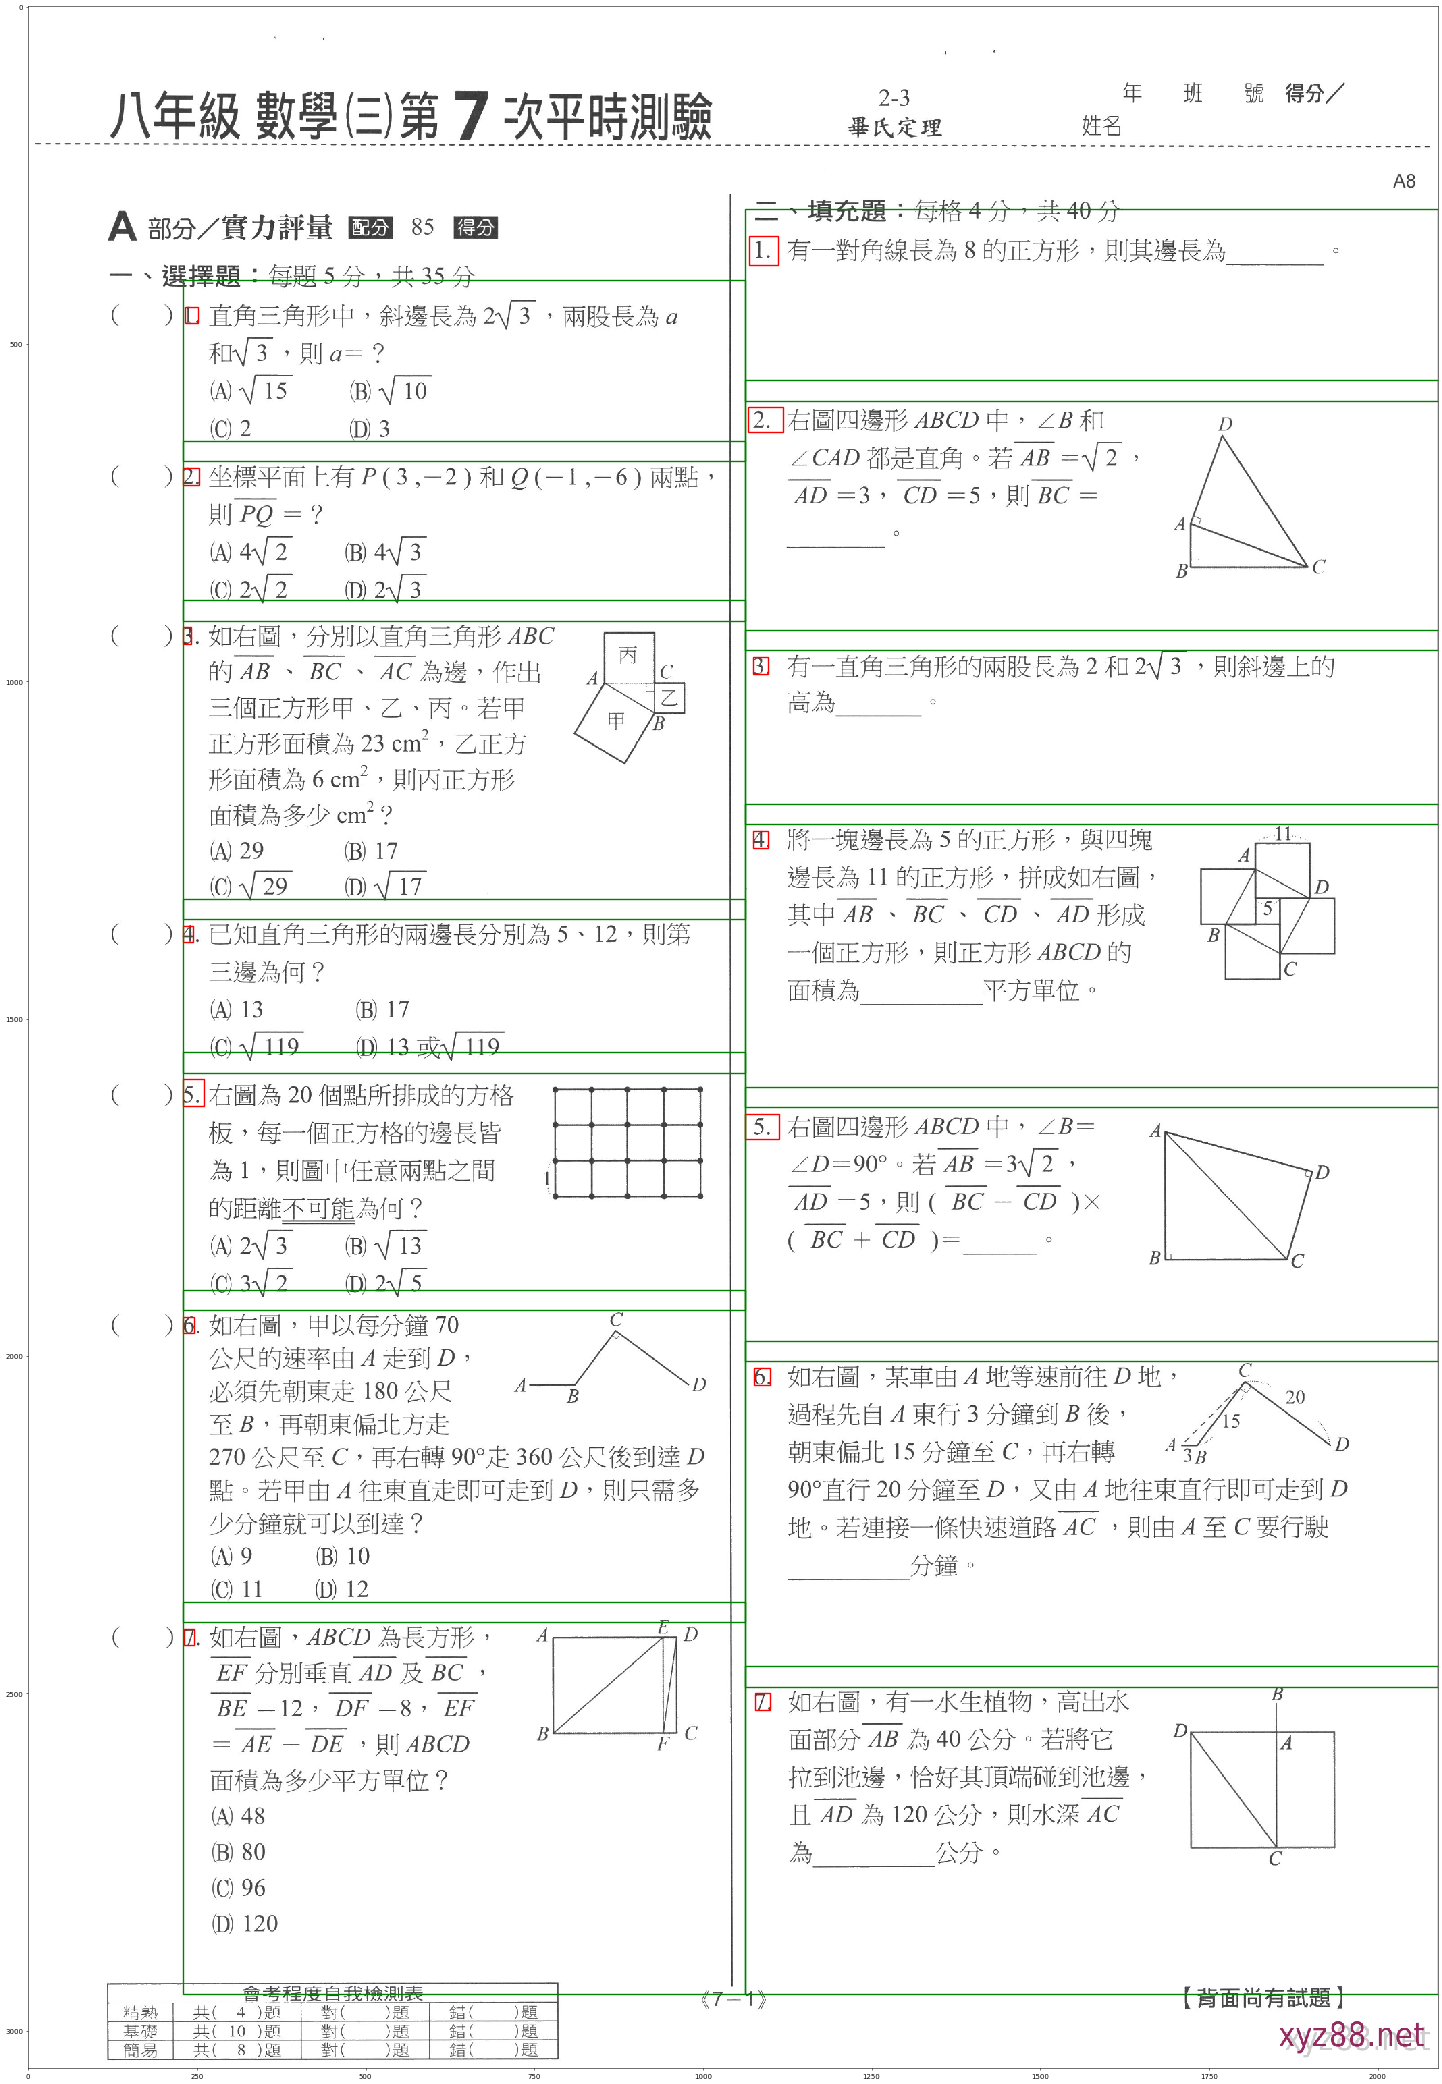

[(0.11148325358851674, 0.1456151832460733), '1']
[(0.11004784688995216, 0.2238219895287958), '2.']
[(0.11004784688995216, 0.3010471204188482), '3']
[(0.10956937799043062, 0.4456806282722513), '4']
[(0.11004784688995216, 0.5202879581151832), '5.']
[(0.11004784688995216, 0.6354712041884817), '6']
[(0.11052631578947368, 0.786976439790576), '7']
[(0.5114832535885168, 0.11125654450261781), '1.']
[(0.5105263157894737, 0.1943717277486911), '2.']
[(0.5138755980861244, 0.31544502617801046), '3.']
[(0.5138755980861244, 0.39986910994764396), '4.']
[(0.5086124401913875, 0.536976439790576), '5.']
[(0.5148325358851674, 0.6603403141361257), '6.']
[(0.5153110047846889, 0.8180628272251309), '7.']


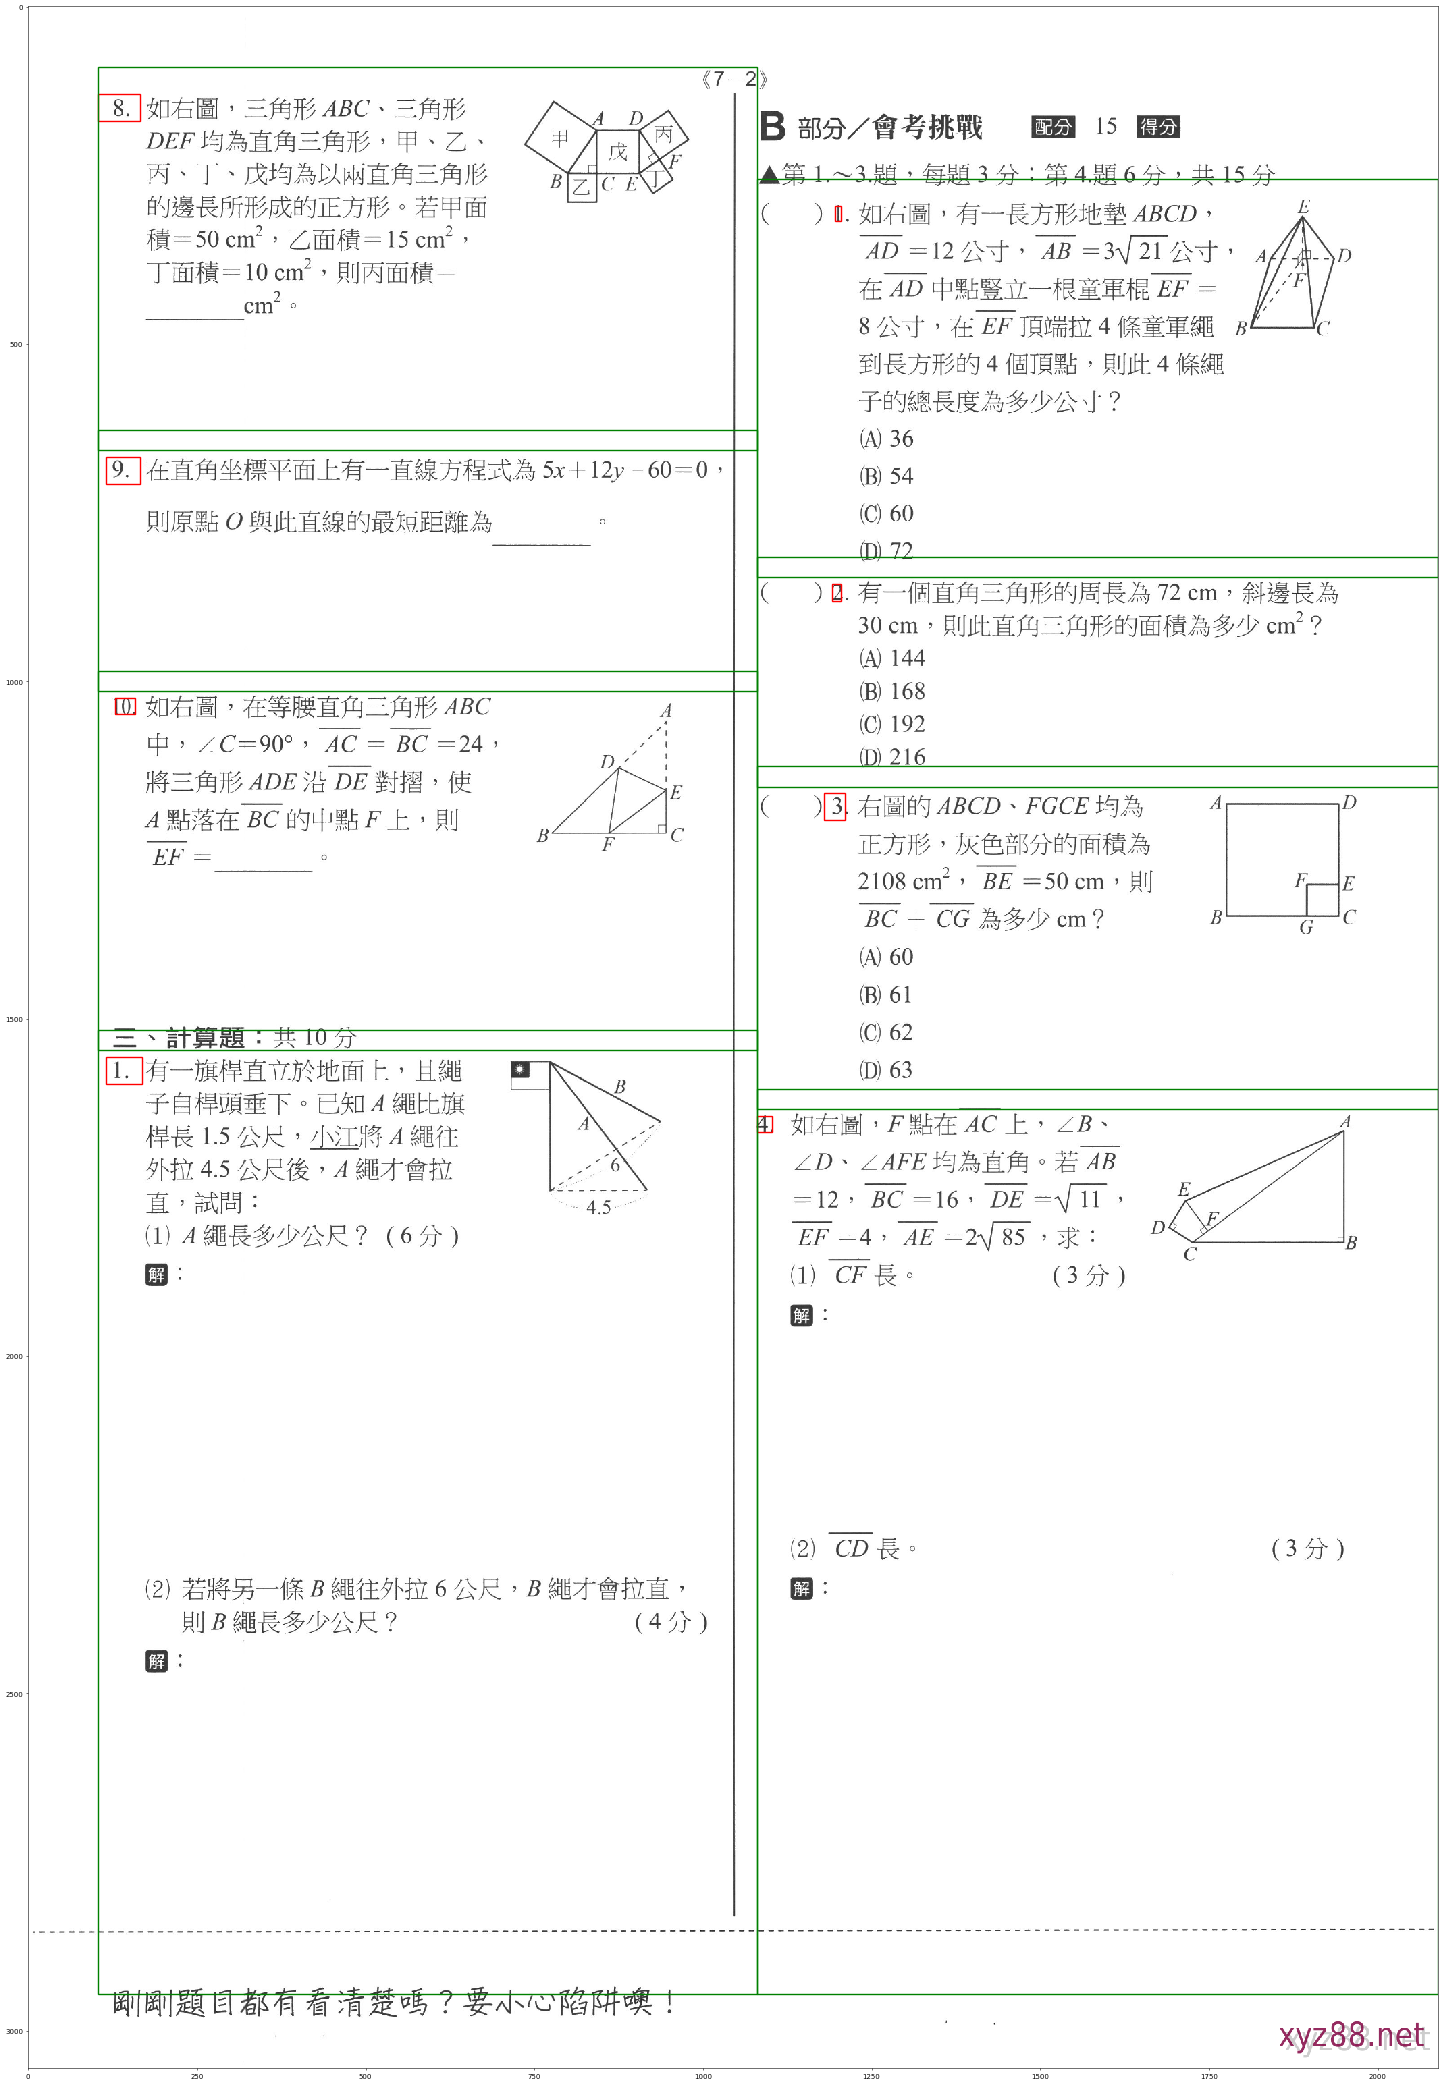

[(0.049760765550239235, 0.04253926701570681), '8.']
[(0.05502392344497608, 0.21825916230366493), '9.']
[(0.06124401913875598, 0.33540575916230364), '10.']
[(0.05550239234449761, 0.5094895287958116), '1.']
[(0.5722488038277512, 0.09653141361256544), '1']
[(0.570334928229665, 0.2801047120418848), '2']
[(0.5645933014354066, 0.38154450261780104), '3']
[(0.5167464114832536, 0.5379581151832461), '4.']


In [207]:
for i in [12, 13]:
    df_paper = paper_log.loc[i]
    paper_path = df_paper['paper_path']
    q_list = df_paper['q_list']

    ocr.show_paper(paper_path, q_list, show_border=True, show_rec=True)
    for q in q_list:
        [xy_float, text] = [q['xy_float'], q['text']]
        print([xy_float, text])
    


In [155]:
# paper_log

In [146]:
def text2number(text='7.2'):
    if '.' in text:
        return int(text[:text.index('.')])
    else:
        return int(text)
    
text2number(text='7.xx')

7

In [156]:
def number_list_to_q_number_list(number_list):
    q_number_list = ['1.1']
    a = 1
    for i in range(1, len(number_list)):
        cur = number_list[i]
        pre = number_list[i-1]
        if pre >= cur:
            a += 1
        q_number = '%s.%s'%(a, number_list[i])
        q_number_list.append(q_number)
    return q_number_list


In [202]:
def check_pair(i_page1, i_page2, paper_log):
    c1 = paper_log.loc[i_page1, 'page'] == paper_log.loc[i_page2, 'page'][:-1] + '1' 
    c2 = paper_log.loc[i_page1, 'pdf_path'] == paper_log.loc[i_page2, 'pdf_path']
    return c1 and c2

i = 12
i_page1 = i
i_page2 = i+1
check_pair(i_page1, i_page2, paper_log)

True

In [203]:
page1_q_list = paper_log.loc[i_page1, 'q_list'] 
page2_q_list = paper_log.loc[i_page2, 'q_list']
q_list = page1_q_list + page2_q_list
number_list = [text2number(q['text']) for q in q_list]
q_number_list = number_list_to_q_number_list(number_list)

In [206]:
page1_q_number_list = q_number_list[:len(page1_q_list)]
page2_q_number_list = q_number_list[len(page1_q_list):]

for i in range(len(page1_q_list)):
    page1_q_list[i]['q_number'] = page1_q_number_list[i]

for i in range(len(page2_q_list)):
    page2_q_list[i]['q_number'] = page2_q_number_list[i]
    
page1_q_list
page2_q_list

[{'coor': {'x1': 104, 'x2': 1080, 'y1': 90, 'y2': 657},
  'q_number': '2.8',
  'rec_height': 39,
  'rec_width': 61,
  'text': '8.',
  'xy': (104, 130),
  'xy_float': (0.049760765550239235, 0.04253926701570681)},
 {'coor': {'x1': 104, 'x2': 1080, 'y1': 627, 'y2': 1015},
  'q_number': '2.9',
  'rec_height': 40,
  'rec_width': 50,
  'text': '9.',
  'xy': (115, 667),
  'xy_float': (0.05502392344497608, 0.21825916230366493)},
 {'coor': {'x1': 104, 'x2': 1080, 'y1': 985, 'y2': 1547},
  'q_number': '2.10',
  'rec_height': 24,
  'rec_width': 30,
  'text': '10.',
  'xy': (128, 1025),
  'xy_float': (0.06124401913875598, 0.33540575916230364)},
 {'coor': {'x1': 104, 'x2': 1080, 'y1': 1517, 'y2': 2946},
  'q_number': '3.1',
  'rec_height': 40,
  'rec_width': 53,
  'text': '1.',
  'xy': (116, 1557),
  'xy_float': (0.05550239234449761, 0.5094895287958116)},
 {'coor': {'x1': 1080, 'x2': 2090, 'y1': 255, 'y2': 846},
  'q_number': '4.1',
  'rec_height': 23,
  'rec_width': 8,
  'text': '1',
  'xy': (1196

### answer

In [ ]:
ocr = Ocr()
pdf_path_list = ocr.pdf_path_list(subject='數學', press='南一', qa='question')
pdf_path = pdf_path_list[0]
images = ocr.pdf2images(pdf_path)

In [ ]:
image = images[4] 
image_byte = ocr.image2byte(image)
res = ocr.detect_text(image_byte)
# image

In [ ]:
# text_annotation_list = res.text_annotations
# for text_annotation in text_annotation_list[1:]:
#     description = text_annotation.description
#     vertices = text_annotation.bounding_poly.vertices
#     print('#'*50)
#     print(description)
# #     print(vertices)

## full_text_annotation

In [ ]:
full_text_annotation = res.full_text_annotation


In [ ]:
pages = full_text_annotation.pages
page = pages[0]
len(pages)

In [ ]:
blocks = page.blocks
block = blocks[0]
len(blocks)

In [ ]:
paragraphs = block.paragraphs
paragraph = paragraphs[0]
len(paragraphs)

In [ ]:
words = paragraph.words
word = words[0]
len(words)

In [ ]:
symbols = word.symbols
symbol = symbols[0]
len(symbols)

In [ ]:
# symbol

# re

In [ ]:
import re


In [ ]:
'''
1.~3.題
3.題,每
'''

In [ ]:
def is_valid_txt(txt):
    #pat = '^([1-9]|[1-2][0-9])(\.)[^0-9]' # 小數點後面不能接數字
    pat = '^([1-9]|[1-2][0-9])(\.)(.)(.)'
    x = re.search(pat, txt)
    if x != None:
        group3 = x.group(3)
        group4 = x.group(4)
        c1 = (group3!='~') # '1.~3.題' 
        c2 = (group3+group4) != '題,' # '3.題,每'
        if c1 and c2:
            return True
    return False

txt = '1.~3.題'
txt = '3.題,每'
txt = '5.因式分解9(x'

x = is_valid_txt(txt)
x